## 0. Load Dataset

In [1]:
from datasets import load_dataset

In [ ]:
cache_dir = "/ocean/projects/cis250208p/shared/datasets"

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("ccvl/3DSRBench", cache_dir=cache_dir)
ds = ds['test']

In [3]:
print(ds)

DatasetDict({
    test: Dataset({
        features: ['index', 'question', 'A', 'B', 'C', 'D', 'answer', 'category', 'image_source', 'image_url'],
        num_rows: 5157
    })
})


In [ ]:
# import random

# random.seed(42)
# indices = random.sample(range(len(ds)), 100)

# from datasets import concatenate_datasets

# # how many total samples to select
# total_samples = 180

# # unique categories
# categories = list(set(ds["category"]))
# samples_per_cat = total_samples // len(categories)

# balanced_subsets = []

# for cat in categories:
#     subset = ds.filter(lambda x: x["category"] == cat)
#     n = min(samples_per_cat, len(subset))  # handle small categories
#     subset = subset.shuffle(seed=42).select(range(n))
#     balanced_subsets.append(subset)

# # combine them and shuffle the final set
# balanced_ds = concatenate_datasets(balanced_subsets).shuffle(seed=42)

# print(f"✅ Balanced dataset size: {len(balanced_ds)}")
# print(balanced_ds['category'][:20])  # preview the categories


In [ ]:
# balanced_ds.save_to_disk("test_dataset_150")

## 1.APC Pipeline

In [ ]:
import os
os.environ['PYGLET_HEADLESS'] = '1'

In [6]:
!nvidia-smi

Mon Nov  3 13:18:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:16:00.0 Off |                    0 |
| N/A   45C    P0            146W /  300W |    6706MiB /  32768MiB |     90%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!kill -9 60009

: 

: 

: 

In [7]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [8]:
cd Ego2Allo-VLM/APC-VLM-idl-baseline

/jet/home/ydinga/Ego2Allo-VLM/APC-VLM-idl-baseline


/jet/home/ydinga/apc_vlm_env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [12]:
from datasets import load_from_disk
ds = load_from_disk("test_dataset_150")

In [14]:
print(ds)

Dataset({
    features: ['index', 'question', 'A', 'B', 'C', 'D', 'answer', 'category', 'image_source', 'image_url'],
    num_rows: 180
})


In [ ]:
import os
import pandas as pd
from APC_runner import APC_runner

model_name = "qwenvl2_5_3b_instruct" # Change this

config_path = f"apc/configs/{model_name}.yaml"

apc_runner = APC_runner(config_path)

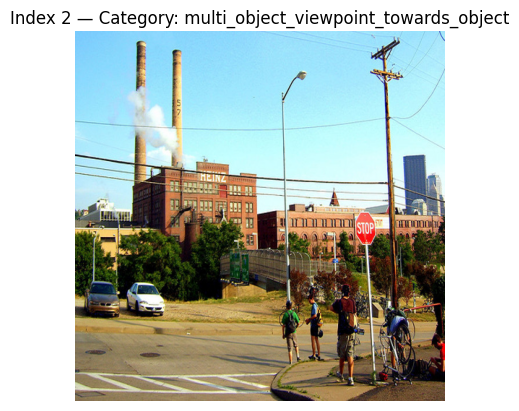

2025-11-03 13:42:18 INFO [httpx] HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"
2025-11-03 13:42:20 INFO [httpx] HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"


* [INFO] Response for VLM detection refinement: The image that best fits the description 'camera' is image 0.
The index is 0.


2025-11-03 13:42:24 INFO [httpx] HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"


* [INFO] Response for VLM detection refinement: The image that best fits the description "person in green shirt" is image 0.


2025-11-03 13:42:28 INFO [httpx] HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"


* [INFO] Response for VLM detection refinement: The image that best fits the description 'stop sign' is image 0.


2025-11-03 13:42:31 INFO [httpx] HTTP Request: POST https://generativelanguage.googleapis.com/v1beta/openai/chat/completions "HTTP/1.1 200 OK"


TypeError: startswith first arg must be bytes or a tuple of bytes, not str

In [ ]:
results = apc_runner.run_single(2, ds[2], verbose=True)
# print(ds[1])
# results = apc_runner.run(verbose=False)
# df = pd.DataFrame(results)
# df.to_csv(f"3DSRBench_raw_predictions_{model_name}.csv", index=False)

In [ ]:
for i in range(5):
    results = apc_runner.run()
    df = pd.DataFrame(results)
    df.to_csv(f"3DSRBench_raw_predictions_{model_name}_{i}.csv", index=False)

# !scancel -u vwei

Evaluating 3DSRBench:   1%|                    | 1/180 [00:42<2:06:51, 42.52s/it]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(results)
df.to_csv("3DSRBench_raw_predictions.csv", index=False)

## Compute metrics

In [ ]:
df = pd.read_csv("3DSRBench_raw_predictions_5.csv")

In [ ]:
metrics = {}

# ---- Overall accuracy ----
metrics["overall_accuracy"] = df["is_correct"].mean()

# # ---- Standard deviation of correctness (robustness) ----
# metrics["std_dev_accuracy"] = df["is_correct"].std()

# ---- Category-wise accuracy ----
cat_acc = df.groupby("category")["is_correct"].mean().to_dict()
for cat, acc in cat_acc.items():
    metrics[f"acc_{cat}"] = acc

In [ ]:

# =======================
# Save results
# =======================
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("3DSRBench_metrics_summary_4.csv", index=False)

print("\n✅ Evaluation Complete!")
print(metrics_df.T)



✅ Evaluation Complete!
                                                  0
overall_accuracy                           0.455556
acc_height_higher                          0.400000
acc_location_above                         0.733333
acc_location_closer_to_camera              0.200000
acc_location_next_to                       0.666667
acc_multi_object_closer_to                 0.333333
acc_multi_object_facing                    0.133333
acc_multi_object_parallel                  0.600000
acc_multi_object_same_direction            0.666667
acc_multi_object_viewpoint_towards_object  0.266667
acc_orientation_in_front_of                0.666667
acc_orientation_on_the_left                0.533333
acc_orientation_viewpoint                  0.266667
